In [94]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot, ProbabilisticDiscreteCurve, SpotNoise
from finance_utils.electrical.china.spot.discrete.testback import TestBack
from finance_utils.electrical.china.spot.rule.recycle import SampleRecycle
import numpy
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution
from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, LogHisDist
from data_utils.stochastic_utils.distributions.discrete.basic import DiscreteDistribution
from matplotlib import pyplot
import tqdm

In [95]:
quantity_min = 0
quantity_max = 30
submitted_min = 0
submitted_max = 30
trigger_rate = 0.05
punishment_rate = 0.5
random_p = 0.0
random_p_2 = 0.9

In [96]:
dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 20),
    NormalDistribution(201, 21),
    NormalDistribution(203, 22),
    NormalDistribution(102, 53),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20 * 1.5),
    NormalDistribution(201 * 0.2, 21 * 1.2),
    NormalDistribution(203 * 1.1, 22 * 1.3),
    NormalDistribution(102 * 0.5, 53 * 1.1),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
], domain_min=quantity_min, domain_max=quantity_max)

spot = DiscreteSpot(dayahead, realtime, quantity)

train_testback = TestBack(spot.diff_random_sample(p=random_p, epoch=100, n=100))
q_test = train_testback.differential_evolution__search(
    quantity.value_list, 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)
mpq = quantity.value_list

In [97]:
noise = SpotNoise(
    [NormalDistribution(50, 50)] * 4,
    [NormalDistribution(0, 50)] * 4,
    [NormalDistribution(0, 5)] * 4,
)

noised_spot = spot.noised_spot(train_testback.samples, noise)
noised_train_testback = TestBack(noised_spot.diff_random_sample(p=random_p, epoch=100, n=100))
noised_submitted_quantity = noised_train_testback.differential_evolution__search(
    noised_spot.quantity.value_list,
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)

In [98]:
random_sample = spot.diff_random_sample(p=random_p_2, epoch=100, n=100)
test_testback = TestBack(random_sample)
noised_testback = TestBack(spot.noised_random_sample(random_sample, noise))
y = test_testback.testback_yield(
    q_test[0],
    trigger_rate=trigger_rate, punishment_rate=punishment_rate
)

cy = test_testback.testback_yield(
    spot.quantity.value_list,
    trigger_rate=trigger_rate, punishment_rate=punishment_rate
)


ny = noised_testback.testback_yield(
    q_test[0], 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)

ncy = noised_testback.testback_yield(
    spot.quantity.value_list, 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)

sy = noised_testback.testback_yield(
    noised_submitted_quantity[0], 
    submitted_min=submitted_min,
    submitted_max=submitted_max,
    trigger_rate=trigger_rate, 
    punishment_rate=punishment_rate
)


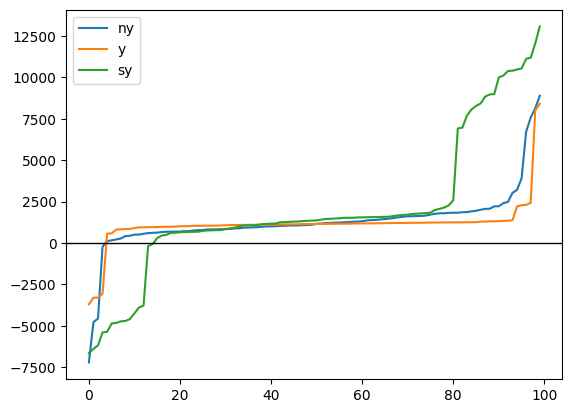

noised:8315.28880448685
noised_control:7011.157408919809
y:6369.7481048678565
control:5240.162401701701
control:9027.637828620273


In [99]:
pyplot.plot(numpy.sort(ny.yield_curve - ncy.yield_curve))
pyplot.plot(numpy.sort(y.yield_curve - cy.yield_curve))
pyplot.plot(numpy.sort(sy.yield_curve - ncy.yield_curve))
pyplot.axhline(0, color='black', linewidth=1)
pyplot.legend(["ny", "y", "sy"])
pyplot.show()
print(f"noised:{ny.mean()}")
print(f"noised_control:{ncy.mean()}")
print(f"y:{y.mean()}")
print(f"control:{cy.mean()}")
print(f"control:{sy.mean()}")

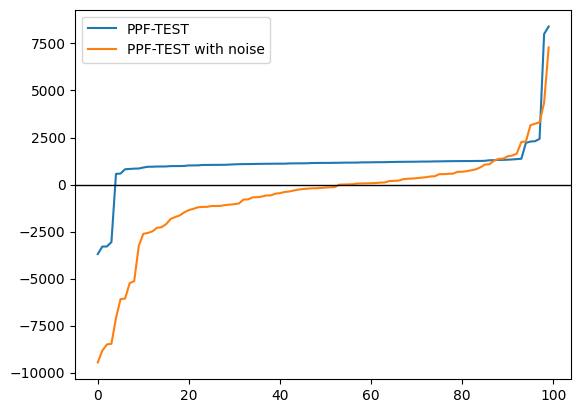

noised:8315.28880448685
noised_control:7011.157408919809
y:6369.7481048678565
control:5240.162401701701
control:9027.637828620273


In [100]:
# pyplot.plot(numpy.sort(cy.yield_curve - cy.yield_curve))
pyplot.plot(numpy.sort(y.yield_curve - cy.yield_curve))
pyplot.plot(numpy.sort(y.yield_curve - ncy.yield_curve))
pyplot.axhline(0, color='black', linewidth=1)
pyplot.legend(["PPF-TEST","PPF-TEST with noise"])
pyplot.show()
print(f"noised:{ny.mean()}")
print(f"noised_control:{ncy.mean()}")
print(f"y:{y.mean()}")
print(f"control:{cy.mean()}")
print(f"control:{sy.mean()}")

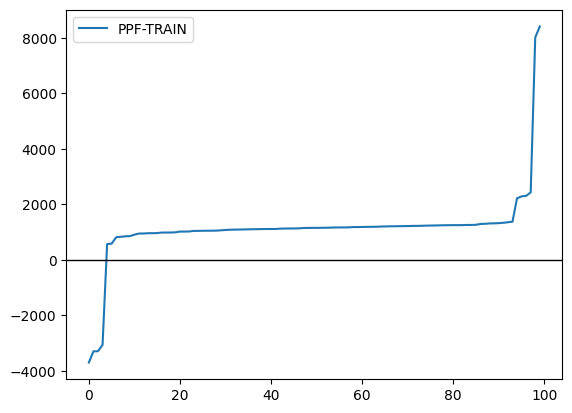

noised:8315.28880448685
noised_control:7011.157408919809
y:6369.7481048678565
control:5240.162401701701
control:9027.637828620273


In [101]:
pyplot.plot(numpy.sort(y.yield_curve - cy.yield_curve))
# pyplot.plot(numpy.sort(y.yield_curve - ncy.yield_curve))
pyplot.axhline(0, color='black', linewidth=1)
pyplot.legend(["PPF-TRAIN"])
pyplot.show()
print(f"noised:{ny.mean()}")
print(f"noised_control:{ncy.mean()}")
print(f"y:{y.mean()}")
print(f"control:{cy.mean()}")
print(f"control:{sy.mean()}")